<a href="https://colab.research.google.com/github/shubhamksingh1/GANs/blob/main/Jupyter_Notebooks/Adversarial_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Chapter 10: Adversarial Examples

Let us start with good old imports.

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
# install foolbox because it is not native to Colab
!pip install foolbox==1.8.0

In [ ]:
!pip install h5py==2.10.0

In [ ]:
import numpy as np
from keras.applications.resnet50 import ResNet50
from foolbox.criteria import Misclassification, ConfidentMisclassification
from keras.preprocessing import image as img
from keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import foolbox
import pprint as pp
import keras
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [ ]:
# Let's get all the necessary files (two images to run data on and a simple CSV)
!wget https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0897.jpg
!wget https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0896.jpg
!wget https://raw.githubusercontent.com/GANs-in-Action/gans-in-action/master/chapter-10/initialization_vals_for_noise.csv

--2022-04-06 13:54:34--  https://github.com/GANs-in-Action/gans-in-action/raw/Chapter-10/chapter-10/DSC_0897.jpg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GANs-in-Action/gans-in-action/Chapter-10/chapter-10/DSC_0897.jpg [following]
--2022-04-06 13:54:34--  https://raw.githubusercontent.com/GANs-in-Action/gans-in-action/Chapter-10/chapter-10/DSC_0897.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3028795 (2.9M) [image/jpeg]
Saving to: ‘DSC_0897.jpg.2’

DSC_0897.jpg.2      100%[===================>]   2.89M  --.-KB/s    in 0.06s   

2022-04-06 13:54:35 (45.3 MB/s) - ‘DSC_0897.jpg.2’ sav

# Helper functions

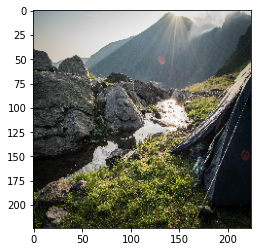

In [ ]:
def load_image(img_path: str):
  image = img.load_img(img_path, target_size=(224, 224))
  plt.imshow(image)
  x = img.img_to_array(image)
  return x

image = load_image('DSC_0897.jpg')

# Attacking one image¶

In [ ]:
# instantiate model
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
# create the foolbox model object from the Keras model
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

# We make the image (1, 224, 224, 3) so that it fits ResNet50
# which expects images for predictions to be in batches
to_classify = np.expand_dims(image, axis=0)
# We call predict and print the results
preds = kmodel.predict(to_classify)
print('Original predictions redicted:', pp.pprint(decode_predictions(preds, top=20)[0]), '\n')
# get the index of the highest number, as a label to be used later
label = np.argmax(preds)

# ::-1 reverses the color channels, because Keras ResNet50 expects BGR instead of RGB
image = image[:, :, ::-1]
# create the attack object, setting high misclassification criteria 
attack = foolbox.attacks.FGSM(fmodel, threshold=.9, criterion=ConfidentMisclassification(.9))
# apply attack on source image
adversarial = attack(image, label)

# get the new predictions on the advesarial image
new_preds = kmodel.predict(np.expand_dims(adversarial, axis=0))
print('Adversarial predictions:', pp.pprint(decode_predictions(new_preds, top=20)[0]))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[('n03792972', 'mountain_tent', 0.6872758),
 ('n09399592', 'promontory', 0.07355866),
 ('n09468604', 'valley', 0.07171775),
 ('n04606251', 'wreck', 0.025214417),
 ('n09428293', 'seashore', 0.018810643),
 ('n01498041', 'stingray', 0.010203822),
 ('n04366367', 'suspension_bridge', 0.00910291),
 ('n02077923', 'sea_lion', 0.008893907),
 ('n09472597', 'volcano', 0.0077157733),
 ('n09421951', 'sandbar', 0.0056634434),
 ('n09193705', 'alp', 0.005281769),
 ('n09256479', 'coral_reef', 0.005070692),
 ('n03042490', 'cliff_dwelling', 0.0048538717),
 ('n03788365', 'mosquito_net', 0.0040941616),
 ('n03450230', 'gown', 0.003981214),
 ('n09246464', 'cliff', 0.0034006056),
 ('n04507155', 'umbrella', 0.002598198),
 ('n09332890', 'lakeside', 0.002416878),
 ('n02951358', 'canoe', 0.0020540701),
 ('n03160309', 'dam', 0.0020333915)]
Original predictions redicted: None 

[('n09472597', 'volcano', 0.5917672),
 ('n04366367', 'su

# Side-by-side comparison

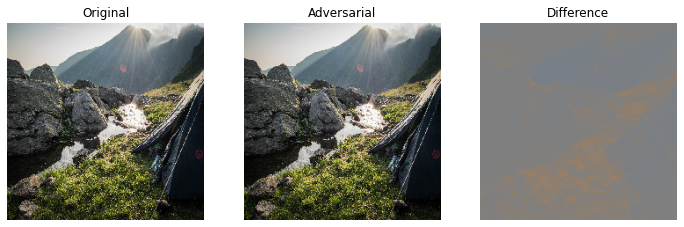

In [ ]:
plt.figure(figsize=(12,12))

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(image[:,:,::-1] / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1] - image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

## Here we just load the means and variances for Gaussian noise.
More is in the `get_vals_for_noise.py` script in this chapter.

In [ ]:
max_vals = pd.read_csv('initialization_vals_for_noise.csv')

## Now run the evaluation script on `ResNet50`

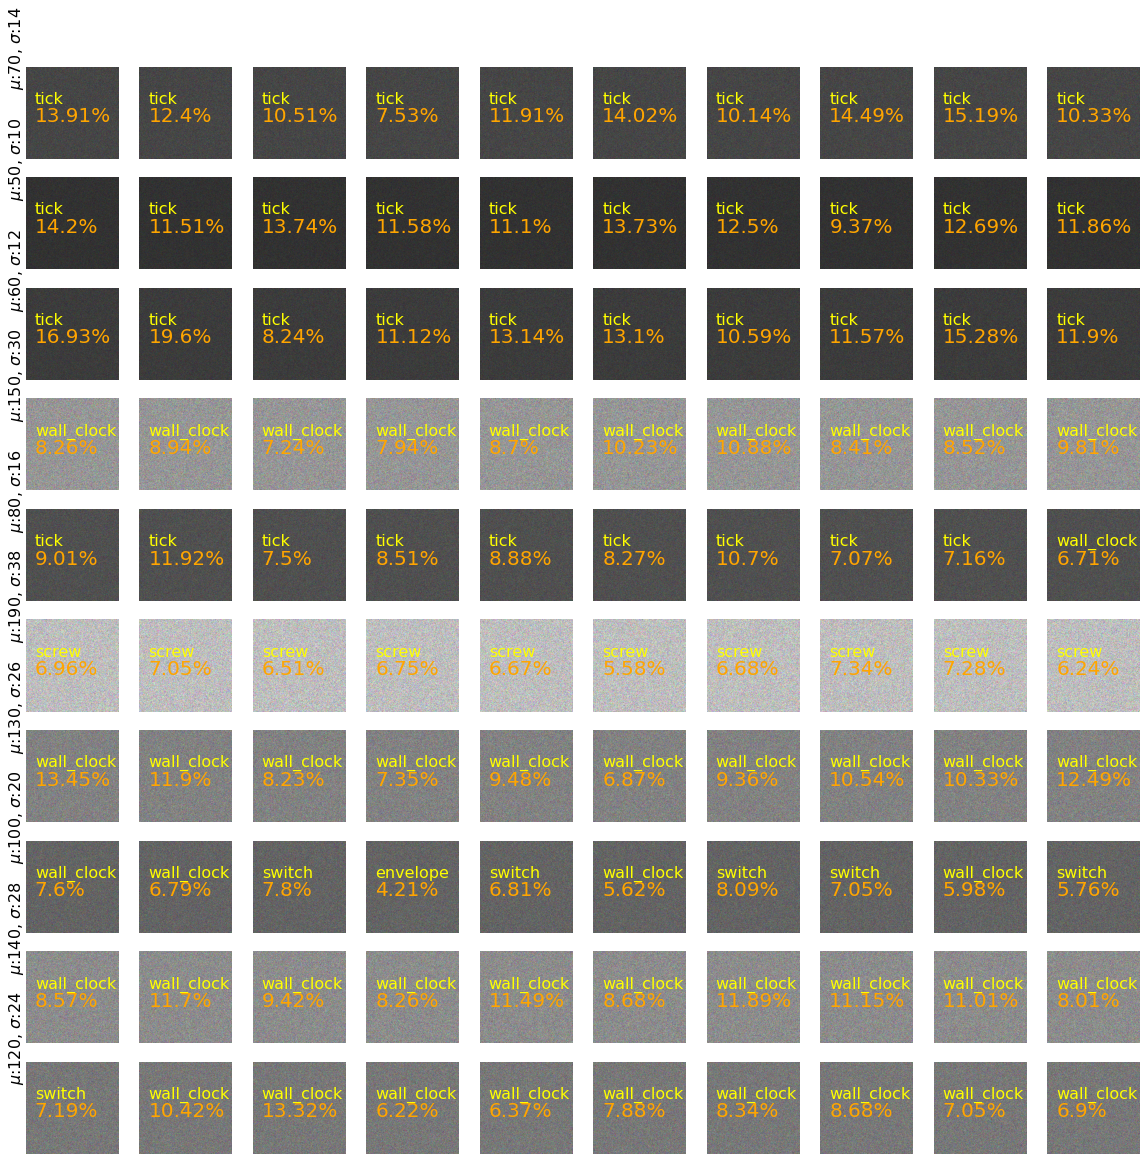

In [ ]:
fig = plt.figure(figsize=(20,20))
# these are just lists of means and variances as floats
sigma_list = list(max_vals.sigma)
mu_list = list(max_vals.mu)
conf_list = []

# this is the core function that 
def make_subplot(x, y, z, new_row=False):
    # sample noise as per for each mean and variance
    rand_noise = np.random.normal(loc=mu, scale=sigma, size=(224,224, 3))
    # only 0-255 pixel values permitted
    rand_noise = np.clip(rand_noise, 0, 255.)
    # get our first prediction
    noise_preds = kmodel.predict(np.expand_dims(rand_noise, axis=0))
    # get the predicted class and confidence respectively
    prediction, num = decode_predictions(noise_preds, top=20)[0][0][1:3]
    num = round(num * 100, 2)
    conf_list.append(num)
    # set up annotating code for the figure and then add the annotations and text
    ax = fig.add_subplot(x,y,z)
    ax.annotate(prediction, xy=(0.1, 0.6), xycoords=ax.transAxes, fontsize=16, color='yellow')
    ax.annotate(f'{num}%' , xy=(0.1, 0.4), xycoords=ax.transAxes, fontsize=20, color='orange')
    if new_row:
        ax.annotate(f'$\mu$:{mu}, $\sigma$:{sigma}' , xy=(-.2, 0.8), xycoords=ax.transAxes,
                    rotation=90, fontsize=16, color='black')
    # division by 255 to convert [0, 255] to [0, 1]
    ax.imshow(rand_noise / 255) 
    ax.axis('off')


# this is the main for-loop that allows us to insert subplots into the figure
for i in range(1,101):
    if (i-1) % 10==0:
        mu = mu_list.pop(0)
        sigma = sigma_list.pop(0)
        make_subplot(10,10, i, new_row=True)
    else:
        make_subplot(10,10, i)

plt.show()

# Now let's try applying an adversarial attack
Keeping `ResNet50` as our prediction network, let's now try to attack the Gaussian noise we have classified above. 

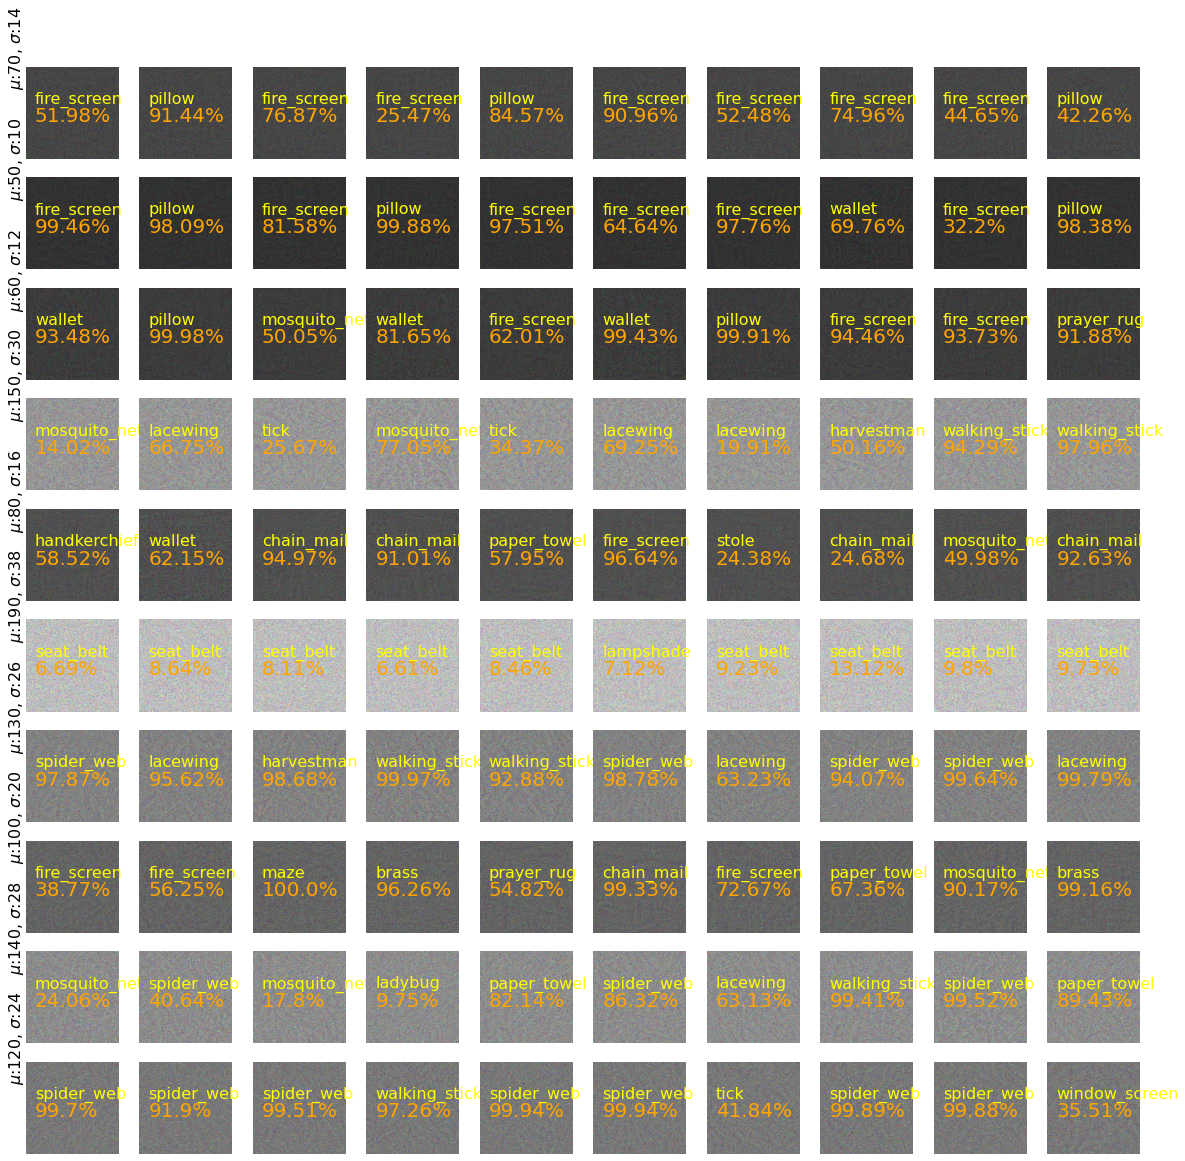

In [ ]:
fig = plt.figure(figsize=(20,20))
sigma_list = list(max_vals.sigma)
mu_list = list(max_vals.mu)
sum_pred = []

def make_subplot(x, y, z, new_row=False):
    rand_noise = np.random.normal(loc=mu, scale=sigma, size=(224,224, 3))
    rand_noise = np.clip(rand_noise, 0, 255.)
    first_pred = kmodel.predict(np.expand_dims(rand_noise, axis=0))
    label = np.argmax(first_pred)
    attack = foolbox.attacks.ProjectedGradientDescentAttack(fmodel, threshold=.999,
                                         distance=foolbox.distances.Linfinity,
                                         criterion=ConfidentMisclassification(.999))
    adversarial = attack(rand_noise[:, :, ::-1], label)
    noise_preds = kmodel.predict(np.expand_dims(adversarial, axis=0))
    prediction, num = decode_predictions(noise_preds, top=20)[0][0][1:3]
    num = round(num * 100, 2)
    sum_pred.append(num)
    ax = fig.add_subplot(x,y,z)
    ax.annotate(prediction, xy=(0.1, 0.6), xycoords=ax.transAxes, fontsize=16, color='yellow')
    ax.annotate(f'{num}%', xy=(0.1, 0.4), xycoords=ax.transAxes, fontsize=20, color='orange')
    if new_row:
        ax.annotate(f'$\mu$:{mu}, $\sigma$:{sigma}' , xy=(-.2, 0.8), xycoords=ax.transAxes,
                    rotation=90, fontsize=16, color='black')
    ax.imshow(adversarial / 255)  # division by 255 to convert [0, 255] to [0, 1]
    ax.axis('off')

    
for i in range(1,101):
    if (i-1) % 10==0:
        mu = mu_list.pop(0)
        sigma = sigma_list.pop(0)
        make_subplot(10,10, i, new_row=True) 
    else:
        make_subplot(10,10, i)

plt.show()

# Now let's try the same thing with `InceptionV3`
This is another standard classifier, which, however, fails spectacularly right out of gate. 

We're now picking the mean and the standard deviation randomly, though we are giving InceptionV3 a bit of a hard time due to lack of proper preprocessing. However, as an attacker, that is exactly the type of challenge we can easily pose to InceptionV3—no machine learning attacks required.

In [ ]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions

# instantiate model
keras.backend.set_learning_phase(0)
kmodel_v3 = InceptionV3(weights='imagenet')

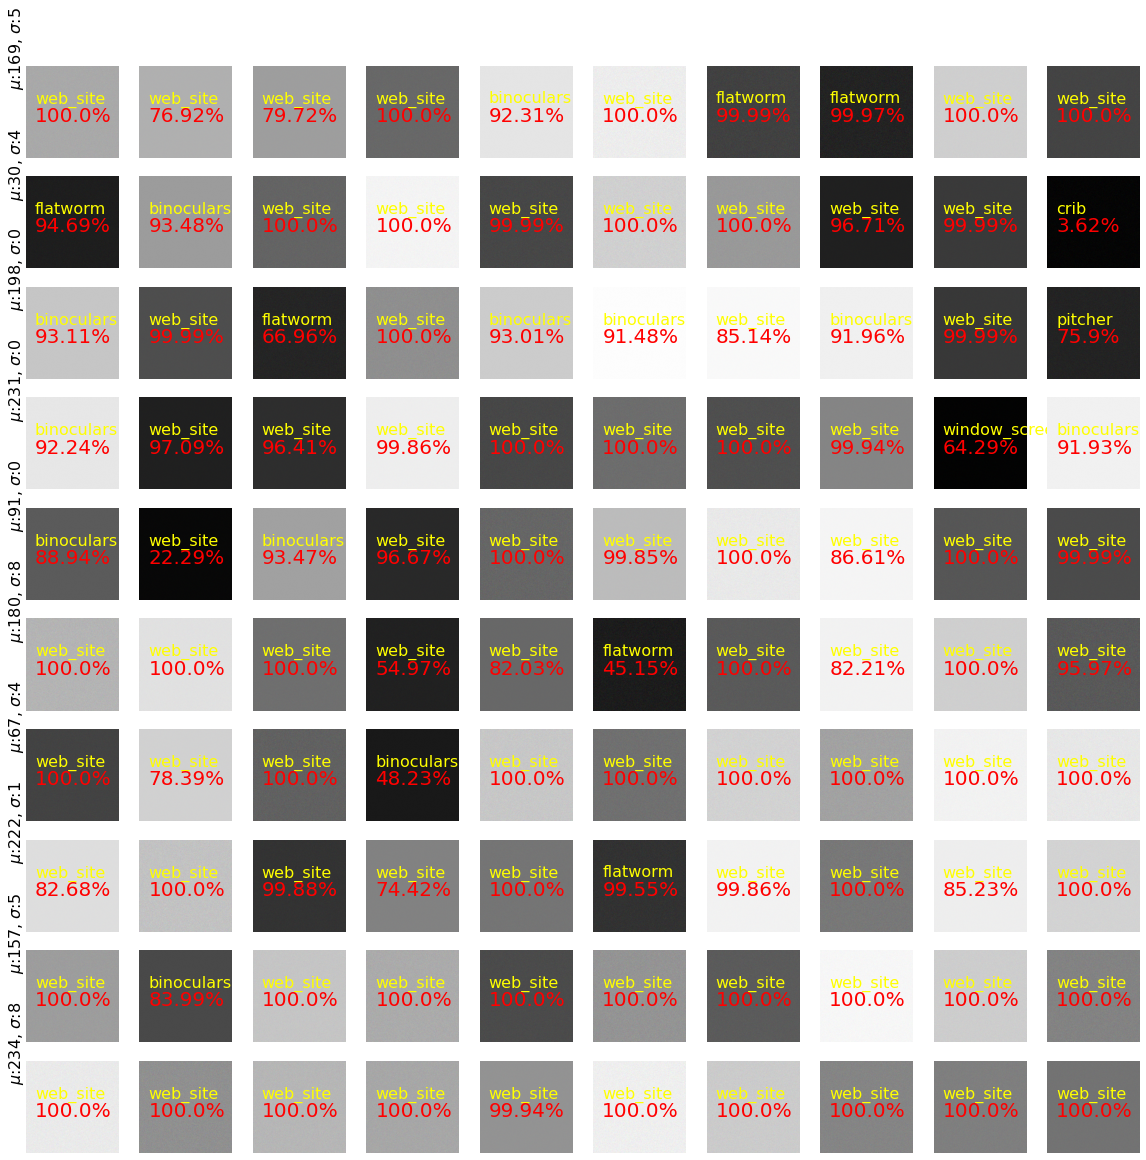

In [ ]:
fig = plt.figure(figsize=(20,20))
conf_list = []

def make_subplot(x, y, z, new_row=False):
    mu = np.random.randint(0, 255)
    sigma = np.random.randint(0, 10)
    rand_noise = np.random.normal(loc=mu, 
                                  scale=sigma, size=(299,299, 3))
    rand_noise = np.clip(rand_noise, 0, 255.)
    noise_preds = kmodel_v3.predict(np.expand_dims(rand_noise, axis=0))
    prediction, num = decode_predictions(noise_preds, top=20)[0][0][1:3]
    num = round(num * 100, 2)
    conf_list.append(num)
    ax = fig.add_subplot(x,y,z)
    ax.annotate(prediction, xy=(0.1, 0.6), xycoords=ax.transAxes, fontsize=16, color='yellow')
    ax.annotate(f'{num}%' , xy=(0.1, 0.4), xycoords=ax.transAxes, fontsize=20, color='red')
    if new_row:
        ax.annotate(f'$\mu$:{mu}, $\sigma$:{sigma}' , xy=(-.2, 0.8), xycoords=ax.transAxes,
                    rotation=90, fontsize=16, color='black')
    ax.imshow(rand_noise / 255)  # division by 255 to convert [0, 255] to [0, 1]
    ax.axis('off')

    
for i in range(1,101):
    if (i-1) % 10==0:
        make_subplot(10,10, i, new_row=True)
    else:
        make_subplot(10,10, i)

plt.show()